In [46]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [47]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
#print(f'Number of nodes: {data.num_nodes}')
#print(f'Number of edges: {data.num_edges}')
#print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
#print(f'Number of training nodes: {data.train_mask.sum()}')
#print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
#print(f'Has isolated nodes: {data.has_isolated_nodes()}')
#print(f'Has self-loops: {data.has_self_loops()}')
#print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


**1 a)** From the Planetoid Cora dataset, extract the number of nodes that are in the training set, validation set, and test set. Discuss briefly the implications for supervised
versus semi-supervised learning.

In [48]:
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')

Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


We dont have very many labeled nodes for training, so supervised learning will struggle. Only being able to train on 140 noded means that it will be hard to learn in a way that generalizes over the whole data set. We do however have quite a number of nodes in validation, so semi-supervised learning could be able to produce better results by inferring labels to the rest of the data set???? 

**b)** Train both a standard dense network using supervised learning and network using the convolution from equation 1 using semi-supervised learning

and 

**c)** In both cases, implement 'early stopping' using the validation set, i.e. the training should evaluate against the validation set to stop training when this fails to improve.

In [49]:
# First a standard dense network
import torch
from torch.nn import Linear
import torch.nn.functional as F
import numpy as np
import copy


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

mlp_model = MLP(hidden_channels=16)
print(mlp_model)


mlp_model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def mlp_train():
      mlp_model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = mlp_model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def mlp_test(model):
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def mlp_validate(saved_models, accuracies):
    test_acc = mlp_test(mlp_model)
    accuracies = np.append(accuracies[1:], test_acc)

    model_copy = copy.deepcopy(mlp_model)
    saved_models = np.append(saved_models[1:], model_copy)
    
    return saved_models, accuracies


# TODO implement early stopping
patience = 20
s_accuracies = np.zeros(patience)
s_models = np.empty(patience)
s_models[:] = np.NaN

for epoch in range(1, 201):
    loss = mlp_train()
    s_models, s_accuracies = mlp_validate(s_models, s_accuracies)
    #print(f'Saved Models: {s_models}')
    print(f'Accuracies: {s_accuracies}')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if s_accuracies[0] == np.max(s_accuracies):
        best_mlp = s_models[0]
        break



MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)
Accuracies: [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.103]
Epoch: 001, Loss: 1.9615
Accuracies: [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.103 0.132]
Epoch: 002, Loss: 1.9557
Accuracies: [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.103 0.132 0.107]
Epoch: 003, Loss: 1.9505
Accuracies: [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.103 0.132 0.107 0.106]
Epoch: 004, Loss: 1.9423
Accuracies: [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.103 0.132 0.107 0.106 0.105]
Epoch: 005, Loss: 1.9327
Accuracies: [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.

In [50]:
test_acc = mlp_test(best_mlp)
print(f'Test Accuracy (best MLP): {test_acc:.4f}')

Test Accuracy (best MLP): 0.5720


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


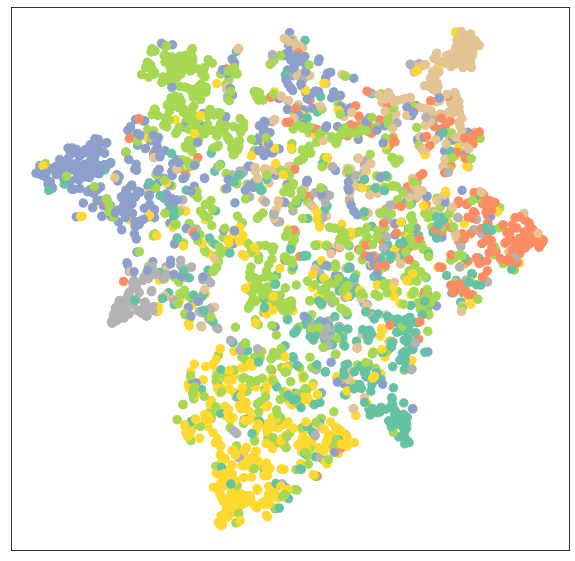

In [51]:
best_mlp.eval()

out = best_mlp(data.x)#, data.edge_index - Only nodes?
visualize(out, color=data.y)

 **Now for the network using graph convolutions**

In [52]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

gcn_model = GCN(hidden_channels=16)
print(gcn_model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [53]:
gcn_model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def gcn_train():
      gcn_model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = gcn_model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def gcn_test(model):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def gcn_validate(saved_models, accuracies):
    test_acc = gcn_test(gcn_model)
    accuracies = np.append(accuracies[1:], test_acc)

    model_copy = copy.deepcopy(gcn_model)
    saved_models = np.append(saved_models[1:], model_copy)
    
    return saved_models, accuracies

patience = 20
s_accuracies = np.zeros(patience)
s_models = np.empty(patience)
s_models[:] = np.NaN

for epoch in range(1, 201):
      loss = gcn_train()
      s_models, s_accuracies = gcn_validate(s_models, s_accuracies)
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

      if s_accuracies[0] == np.max(s_accuracies):
        best_gcn = s_models[0]
        break

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9397
Epoch: 003, Loss: 1.9350
Epoch: 004, Loss: 1.9279
Epoch: 005, Loss: 1.9187
Epoch: 006, Loss: 1.9115
Epoch: 007, Loss: 1.9032
Epoch: 008, Loss: 1.8911
Epoch: 009, Loss: 1.8855
Epoch: 010, Loss: 1.8723
Epoch: 011, Loss: 1.8590
Epoch: 012, Loss: 1.8506
Epoch: 013, Loss: 1.8350
Epoch: 014, Loss: 1.8292
Epoch: 015, Loss: 1.8108
Epoch: 016, Loss: 1.8010
Epoch: 017, Loss: 1.7890
Epoch: 018, Loss: 1.7752
Epoch: 019, Loss: 1.7497
Epoch: 020, Loss: 1.7430
Epoch: 021, Loss: 1.7419
Epoch: 022, Loss: 1.7190
Epoch: 023, Loss: 1.6953
Epoch: 024, Loss: 1.6846
Epoch: 025, Loss: 1.6622
Epoch: 026, Loss: 1.6432
Epoch: 027, Loss: 1.6315
Epoch: 028, Loss: 1.5924
Epoch: 029, Loss: 1.5925
Epoch: 030, Loss: 1.5740
Epoch: 031, Loss: 1.5494
Epoch: 032, Loss: 1.5583
Epoch: 033, Loss: 1.5199
Epoch: 034, Loss: 1.5044
Epoch: 035, Loss: 1.4792
Epoch: 036, Loss: 1.4697
Epoch: 037, Loss: 1.4162
Epoch: 038, Loss: 1.4125
Epoch: 039, Loss: 1.3977
Epoch: 040, Loss: 1.3814


In [54]:
test_acc = gcn_test(best_gcn)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8130


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


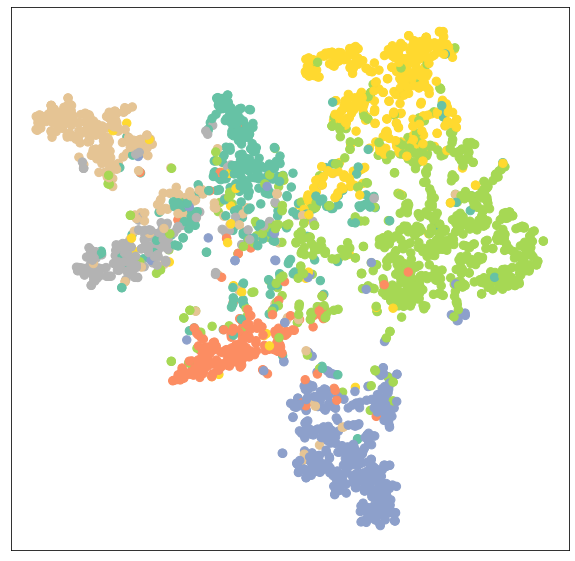

In [55]:
gcn_model.eval()

out = gcn_model(data.x, data.edge_index)
visualize(out, color=data.y)

**2)** Try to outperform the results from (1) using one of the more advances algorithms such as the graph attention network, from eqn. 3-4. Try to optimize performance, varying the number of heads (for GAT), different pooling layers, dropout, etc. (Extensive hyper-parameter tuning however is not asked for.)

It may not be that easy to improve the results from (1) much (see Cora Benchmark), the main objective here is to show that you have tried.

# Dataset 2 
- Divide the dataset 80/20 into a training set and a test set. (If you want to, use a partition of the training set for validation.)
- Design a graph neural network with the objective to optimize the accuracy on the test set. Make sure to make use of the edge weights.


In [107]:
data = torch.load('graph_list_2022.pt')

In [111]:
from sklearn.model_selection import train_test_split
import random


shuffled_data = random.sample(data, len(data)) # Returns new shuffled list

train_sz = int(0.6*len(data))
val_sz = int(0.8*len(data))

train_data = shuffled_data[0:train_sz]
val_data = shuffled_data[train_sz:val_sz]
test_data = shuffled_data[val_sz:]

print(data[0:3])
train_x = np.array(([graph.x for graph in train_data]))
train_edge_i = np.array([graph.edge_index for graph in train_data])
train_edge_w = np.array([graph.edge_attr for graph in train_data])
train_y = np.array([graph.y for graph in train_data])
print(train_x)

[Data(x=[6, 4], edge_index=[2, 30], edge_attr=[30, 1], y=[1, 4]), Data(x=[11, 4], edge_index=[2, 110], edge_attr=[110, 1], y=[1, 4]), Data(x=[7, 4], edge_index=[2, 42], edge_attr=[42, 1], y=[1, 4])]
[tensor([[0.0000, 1.0000, 0.1429, 0.0000],
         [1.0000, 0.0000, 0.1429, 0.4286],
         [0.0000, 1.0000, 0.1429, 0.5714],
         [0.0000, 1.0000, 0.2857, 0.4286],
         [1.0000, 0.0000, 0.2857, 0.5714],
         [0.0000, 1.0000, 0.4286, 0.0000],
         [1.0000, 0.0000, 0.4286, 0.1429],
         [0.0000, 1.0000, 0.5714, 0.1429],
         [0.0000, 1.0000, 0.5714, 0.4286],
         [0.0000, 1.0000, 0.7143, 0.5714]])
 tensor([[1.0000, 0.0000, 0.0000, 0.8571],
         [1.0000, 0.0000, 0.1429, 0.7143],
         [0.0000, 1.0000, 0.7143, 0.0000],
         [1.0000, 0.0000, 0.7143, 0.1429],
         [0.0000, 1.0000, 0.8571, 0.1429]])
 tensor([[1.0000, 0.0000, 0.4286, 0.1429],
         [0.0000, 1.0000, 0.4286, 0.2857],
         [0.0000, 1.0000, 0.5714, 0.1429],
         [1.0000, 0.0000,

C:\Users\Admin\AppData\Local\Temp\ipykernel_16516\34705802.py:15: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  train_x = np.array(([graph.x for graph in train_data]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_16516\34705802.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_x = np.array(([graph.x for graph in train_data]))
C:\Users\Admin\AppData\Local\Tem

In [91]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, edge_weights):
        x = self.conv1(x, edge_index, edge_weights)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weights)
        return x

gcn_model = GCN(hidden_channels=16)
print(gcn_model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [92]:
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def gcn_train():
      gcn_model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = gcn_model(train_x, train_edge_i, train_edge_w)  # Perform a single forward pass.
      loss = criterion(out, train_y)  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def gcn_test(model):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def gcn_validate(saved_models, accuracies):
    test_acc = gcn_test(gcn_model)
    accuracies = np.append(accuracies[1:], test_acc)

    model_copy = copy.deepcopy(gcn_model)
    saved_models = np.append(saved_models[1:], model_copy)
    
    return saved_models, accuracies

patience = 20
s_accuracies = np.zeros(patience)
s_models = np.empty(patience)
s_models[:] = np.NaN

for epoch in range(1, 201):
      loss = gcn_train()
      s_models, s_accuracies = gcn_validate(s_models, s_accuracies)
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

      if s_accuracies[0] == np.max(s_accuracies):
        best_gcn = s_models[0]
        break

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray